In [2]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import chirality_tools as chir
from numba import jit

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

# Initialization

In [3]:
N = 100
a = params["lattice_constant"]
afstate_path = '../data/states/af2'
trj = pd.read_csv(os.path.join(afstate_path,f'{N}.csv'))
trj


,id,x,y,z,dx,dy,dz,cx,cy,cz
0,0,4.187006,0.000000,0.0,-1.000000e+00,-0.0,-0.0,-1.500000e+00,-0.0,-0.0
1,1,12.561017,0.000000,0.0,1.000000e+00,0.0,0.0,1.500000e+00,0.0,0.0
2,2,20.935029,0.000000,0.0,-1.000000e+00,-0.0,-0.0,-1.500000e+00,-0.0,-0.0
3,3,29.309040,0.000000,0.0,1.000000e+00,0.0,0.0,1.500000e+00,0.0,0.0
4,4,37.683052,0.000000,0.0,-1.000000e+00,-0.0,-0.0,-1.500000e+00,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...
19995,19995,795.531096,833.214148,0.0,6.123234e-17,1.0,0.0,9.184851e-17,1.5,0.0
19996,19996,803.905108,833.214148,0.0,-6.123234e-17,-1.0,-0.0,-9.184851e-17,-1.5,-0.0
19997,19997,812.279119,833.214148,0.0,6.123234e-17,1.0,0.0,9.184851e-17,1.5,0.0
19998,19998,820.653131,833.214148,0.0,-6.123234e-17,-1.0,-0.0,-9.184851e-17,-1.5,-0.0


# Simulated annealing

In [4]:
file_path = f'../data/q2_degeneracy/s{N}.csv'
trj_final = pd.read_csv(file_path, index_col=['realization','frame','id'])
trj = trj_final.loc[idx[1,:,:]]
trj

x           y    z            dx   dy   dz  \
frame id                                                           
0     0        4.187006    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      1       12.561017    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      2       20.935029    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      3       29.309040    0.000000  0.0  1.000000e+00  0.0  0.0   
      4       37.683052    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
...                 ...         ...  ...           ...  ...  ...   
      19995  795.531096  833.214148  0.0  6.123234e-17  1.0  0.0   
      19996  803.905108  833.214148  0.0 -6.123234e-17 -1.0 -0.0   
      19997  812.279119  833.214148  0.0 -6.123234e-17 -1.0 -0.0   
      19998  820.653131  833.214148  0.0  6.123234e-17  1.0  0.0   
      19999  829.027142  833.214148  0.0  6.123234e-17  1.0  0.0   

                       cx   cy   cz  
frame id                             
0     0     -1.500000e+00 -0.0 -0.0  
      1     -1.500000e+00 -0.0 -0.0  
      2     -1.500000e+00 -0.0 -0.0  
      3      1.500000e+00  0.0  0.0  
      4     -1.500000e+00 -0.0 -0.0  
...                   ...  ...  ...  
      19995  9.184851e-17  1.5  0.0  
      19996 -9.184851e-17 -1.5 -0.0  
      19997 -9.184851e-17 -1.5 -0.0  
      19998  9.184851e-17  1.5  0.0  
      19999  9.184851e-17  1.5  0.0  

[20000 rows x 9 columns]

# Visualization

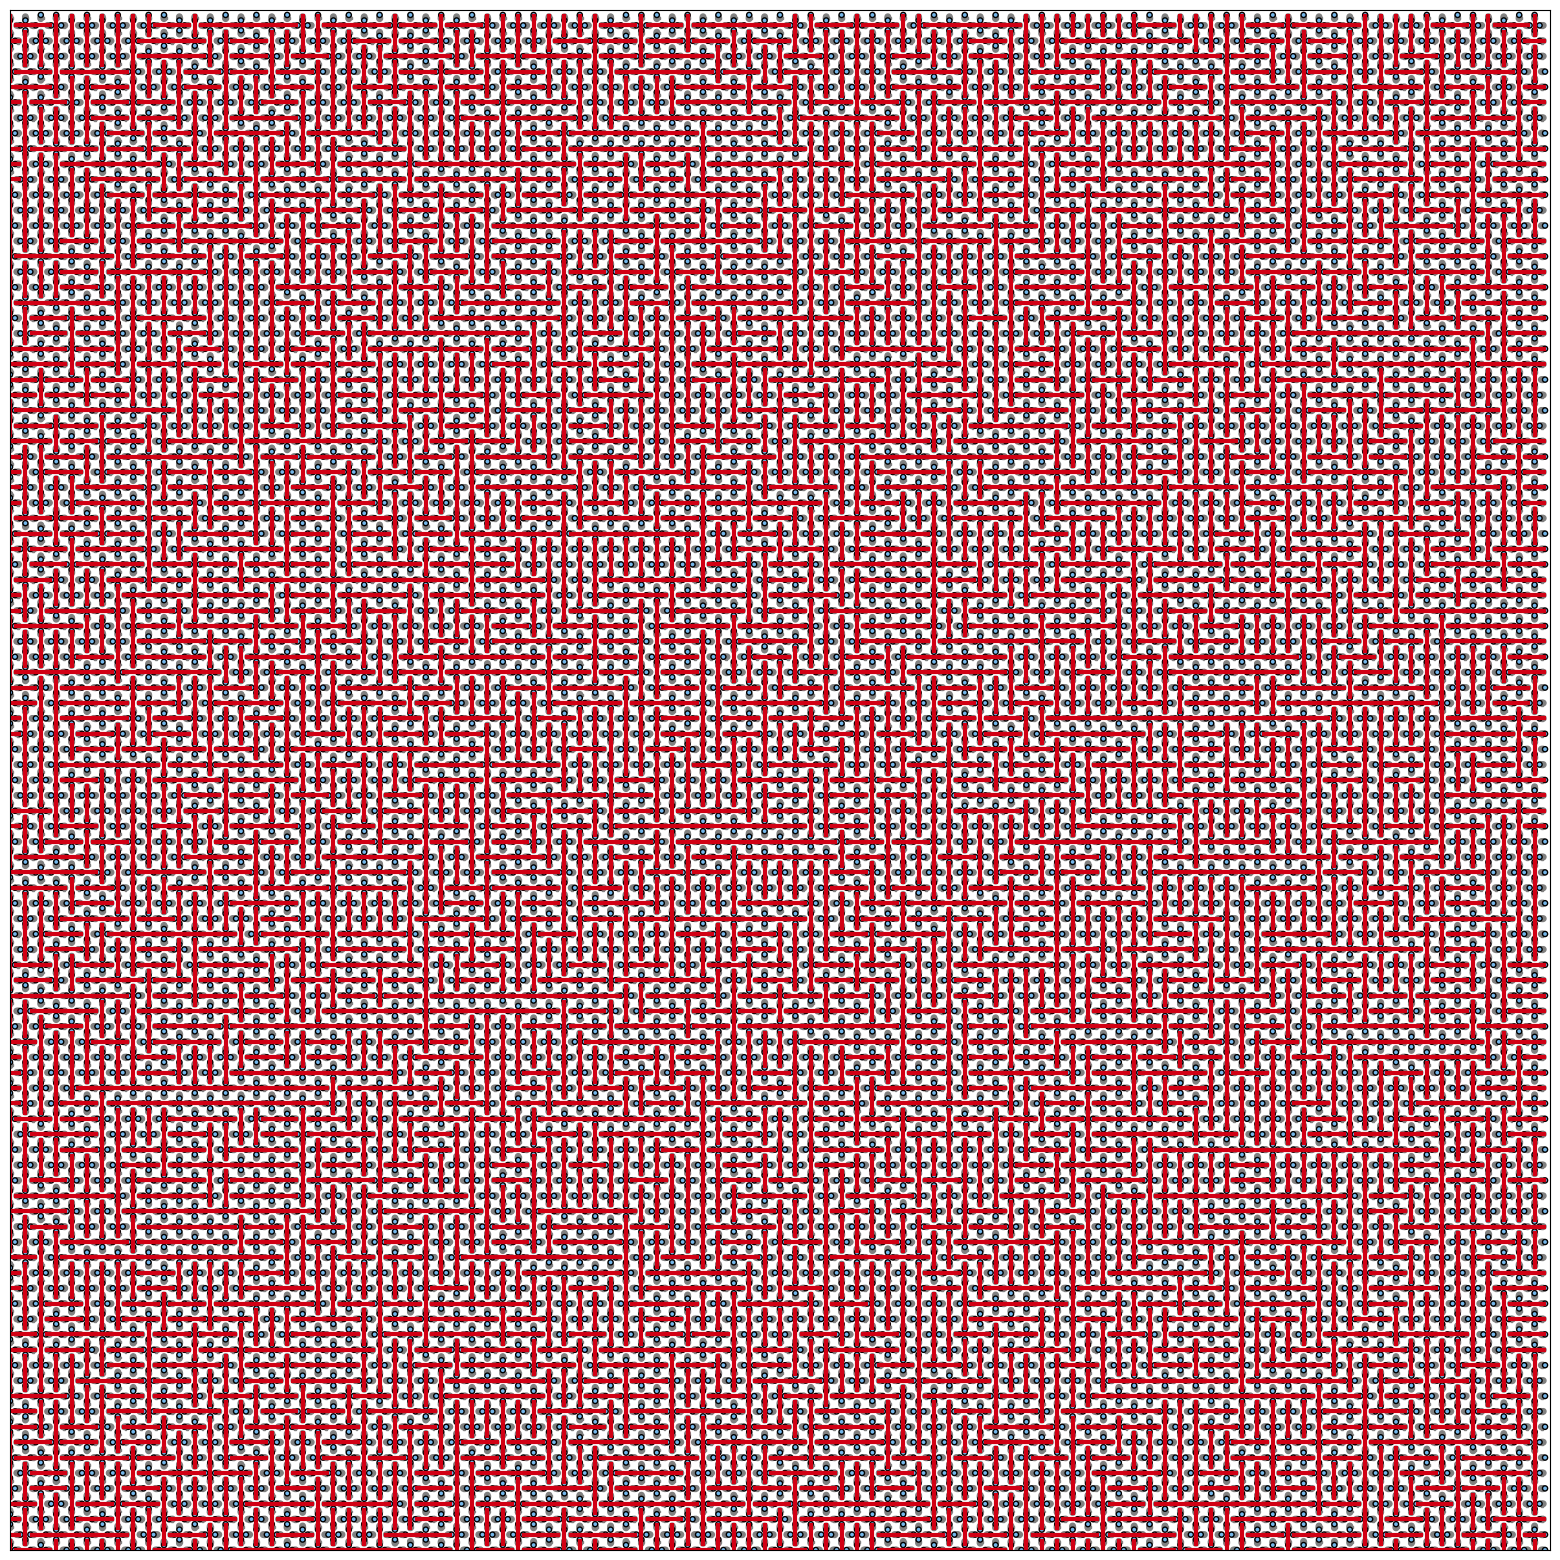

In [11]:
fig, ax= plt.subplots(figsize=(20,20))


region_limit = N*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=0,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

#mc.display_vertices(trj,N,a,ax)
#mc.display_arrows(trj,N,a,ax)
mc.display_lines(trj,N,a,ax)

plt.show()